In [1]:
import cvxpy as cp
import numpy as np
import scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import vectorized_sdr as vect

# Same thing as with cvxpy_vectorized_qcqp but without the dynamics
np.random.seed(0)

In [2]:
N_omega = 5
n = 0
W_plus = np.random.random((N_omega, N_omega))
W_minus = np.random.random((N_omega, N_omega))
J = 0.25*(W_plus@W_plus.conj().T + W_minus@W_minus.conj().T - 2*np.eye(N_omega))
X = np.vstack([J, W_plus, W_minus])
vect_W_plus = vect.mat_to_vec(W_plus)
vect_W_minus = vect.mat_to_vec(W_minus)
vect_J = vect.mat_to_vec(J)
random_mat = np.random.random((N_omega, N_omega))
x = sparse.vstack([vect_J, vect_W_plus, vect_W_minus])
y = sparse.vstack([x, 1])

In [3]:
# Let's try matrix equality of W_plus and W_minus to be something other than identity and then let us relax the matrix equalities a little
proj = np.zeros((N_omega, N_omega))
lin_terms = []
#cst_terms = []
J_def_quad = []
cst_terms_def = []
#lin_terms_W_plus_list = []
#lin_terms_W_minus_list = []
lin_terms_J_def = []
for i in range(N_omega):
    for j in range(N_omega):
        projection = proj.copy()
        projection[i, j] = 1
        #cst_terms.append(0.5*np.trace(projection + projection.conj().T))
        lin_terms.append(vect.mat_to_vec(projection))
        diags = np.zeros((3*(N_omega**2), 3*(N_omega**2)))
        diags[N_omega**2:2*(N_omega**2), N_omega**2:2*(N_omega**2)] = np.kron(np.eye(N_omega), projection)
        diags[2*(N_omega**2):3*(N_omega**2), 2*(N_omega**2):3*(N_omega**2)] = np.kron(np.eye(N_omega), projection)
        J_def_quad.append(sparse.csc_matrix(diags))
        cst_terms_def.append(-np.trace(projection + projection.conj().T))
for i in range(N_omega**2):
    #lin_terms_W_plus_list.append(sparse.vstack([sparse.csc_matrix((N_omega**2, 1)), lin_terms[i], sparse.csc_matrix((N_omega**2, 1))]))
    #lin_terms_W_minus_list.append(sparse.vstack([sparse.csc_matrix((N_omega**2, 1)), sparse.csc_matrix((N_omega**2, 1)), lin_terms[i]]))
    lin_terms_J_def.append(sparse.vstack([-4*lin_terms[i], sparse.csc_matrix((N_omega**2, 1)), sparse.csc_matrix((N_omega**2, 1))]))

In [4]:
#sdr_mat_W_plus = [sparse.bmat([[sparse.csc_matrix((3*(N_omega**2),3*(N_omega**2))), 0.5*lin_terms_W_plus_list[i]],[0.5*lin_terms_W_plus_list[i].conj().T, -cst_terms[i]]]) for i in range(len(lin_terms_W_plus_list))]
#sdr_mat_W_minus = [sparse.bmat([[sparse.csc_matrix((3*(N_omega**2),3*(N_omega**2))), 0.5*lin_terms_W_minus_list[i]],[0.5*lin_terms_W_minus_list[i].conj().T, -cst_terms[i]]]) for i in range(len(lin_terms_W_minus_list))]
sdr_mat_J_def = [sparse.bmat([[J_def_quad[i], 0.5*lin_terms_J_def[i]],[0.5*lin_terms_J_def[i].conj().T, cst_terms_def[i]]]) for i in range(len(lin_terms_J_def))]

In [5]:
[(y.conj().T@sdr_mat_J_def[i]@y).trace() for i in range(len(sdr_mat_J_def))]

[-4.440892098500626e-16,
 0.0,
 0.0,
 0.0,
 -2.220446049250313e-16,
 0.0,
 -4.440892098500626e-16,
 4.440892098500626e-16,
 -2.220446049250313e-16,
 0.0,
 0.0,
 4.440892098500626e-16,
 4.440892098500626e-16,
 0.0,
 0.0,
 0.0,
 -2.220446049250313e-16,
 0.0,
 0.0,
 3.3306690738754696e-16,
 -2.220446049250313e-16,
 0.0,
 0.0,
 3.3306690738754696e-16,
 0.0]

In [6]:
obj_quad = sparse.kron(sparse.eye(N_omega), -sparse.eye(N_omega))
obj_quad.resize((3*(N_omega**2), 3*(N_omega**2)))
obj_quad = sparse.bmat([[obj_quad, sparse.csc_matrix((3*(N_omega**2), 1))],[sparse.csc_matrix((1,3*(N_omega**2))), n]])

In [7]:
constraint_unit = sparse.bmat([[sparse.csc_matrix((3*(N_omega**2), 3*(N_omega**2))), sparse.csc_matrix((3*(N_omega**2), 1))],[sparse.csc_matrix((1, 3*(N_omega**2))), sparse.eye(1)]])

In [11]:
total_constraints = sdr_mat_J_def.copy() #+ sdr_mat_W_plus + sdr_mat_W_minus
total_constraints.append(constraint_unit)
variable = cp.Variable(shape = (3*(N_omega**2) + 1, 3*(N_omega**2) + 1))
constraints = [variable >> 0]
constraints += [cp.trace(sdr_mat_J_def[i]@variable) == 0 for i in range(len(sdr_mat_J_def))]
#constraints += [cp.trace(sdr_mat_W_plus[i]@variable) == 0 for i in range(len(sdr_mat_W_plus))]
#constraints += [cp.trace(sdr_mat_W_minus[i]@variable) == 0 for i in range(len(sdr_mat_W_minus))]
constraints.append(cp.trace(constraint_unit@variable) == 1)
constraints.append(cp.trace(obj_quad@variable) >= 0 )
problem = cp.Problem(cp.Minimize(cp.trace(obj_quad@variable)), constraints)

In [12]:
[(y.conj().T@total_constraints[i]@y).toarray()[0,0] for i in range(len(total_constraints)) if np.abs((y.conj().T@total_constraints[i]@y).toarray()[0,0]) > 10**-9]

[1.0]

In [13]:
problem.solve(solver = "CLARABEL", verbose = True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 09 01:45:13 PM: Your problem has 5776 variables, 28 constraints, and 0 parameters.
(CVXPY) Feb 09 01:45:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 09 01:45:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 09 01:45:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 09 01:45:13 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 09 01:45:13 PM: Compiling problem (target solver=CLARABEL

-9.868252432446417e-10

In [43]:
np_variable = np.array(variable.value)

In [45]:
test_vec_W_minus = np_variable[2*(N_omega**2):3*(N_omega**2), -1]
test_vec_W_plus = np_variable[(N_omega**2):2*(N_omega**2), -1]
test_vec_J = np_variable[:(N_omega**2), -1]

In [ ]:
vect

In [11]:
(vect_W_plus@vect_W_plus.conj().T).toarray()

array([[1., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 1.]])

In [22]:
np_variable[N_omega**2:2*(N_omega**2), N_omega**2:2*(N_omega**2)]

array([[ 1.00018824e+00, -1.51556391e-18, -1.26687167e-19,
         1.00001691e+00],
       [ 4.89361576e-19,  1.71330078e-04, -9.03698390e-20,
        -2.31678463e-19],
       [-1.26687167e-19, -9.03698390e-20,  1.71330080e-04,
        -1.30674945e-18],
       [ 1.00001691e+00, -2.31678463e-19,  6.98175815e-19,
         1.00018824e+00]])

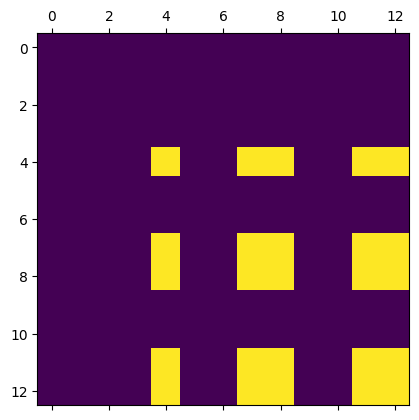

In [15]:
plt.matshow(np_variable)